# FISH comparison

In [1]:
import pandas as pd
import seaborn as sns
import scanpy as sc
import scipy.sparse as sparse
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import itertools

In [2]:
dropseq = pd.read_csv('/data_volume/memento/saver/melanoma_dropseq.csv', index_col=0, sep=',').T

In [3]:
smfish = pd.read_csv('/data_volume/memento/saver/fishSubset.txt', index_col=0, sep=' ')
# smfish = pd.read_csv('fishSubset (1).txt', sep=' ', index_col=0)

### Run memento for DropSeq

In [4]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.7-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [5]:
adata = sc.AnnData(X=sparse.csr_matrix(dropseq.values), obs=pd.DataFrame(index=dropseq.index), var=pd.DataFrame(index=dropseq.columns))

In [6]:
# sc.pp.filter_cells(adata, min_counts=500,)
# sc.pp.filter_cells(adata, max_counts=10000)

In [7]:
adata.obs['q'] = 0.2

In [8]:
adata.obs['group'] = 'A'

In [9]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.02,trim_percent=0.1)

Version 0.0.6


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.7-py3.8.egg/memento/main.py:70: RankWarning: Polyfit may be poorly conditioned


In [10]:
# size_factor = adata[:, 'GAPDH'].X.todense().A1+1
adata.obs['memento_size_factor'] = 1 #size_factor/size_factor.mean()

In [11]:
memento.create_groups(adata, label_columns=['group'])

In [12]:
memento.compute_1d_moments(adata)

In [13]:
dropseq_m, dropseq_v, _ = adata.uns['memento']['1d_moments']['sg^A']

In [14]:
naive_m, naive_v = adata.X.mean(axis=0).A1, adata.X.toarray().var(axis=0)

### Compute fish mean and variance

In [15]:
keep_genes = smfish.columns.tolist()

In [16]:
overlap_genes = list(set(adata.var.index) & set(keep_genes))

In [17]:
overlap_gene_idxs = np.array([adata.var.index.tolist().index(g) for g in overlap_genes])

In [18]:
len(overlap_genes)

14

In [19]:
dropseq_m, dropseq_v, naive_m, naive_v = dropseq_m[overlap_gene_idxs], dropseq_v[overlap_gene_idxs], naive_m[overlap_gene_idxs], naive_v[overlap_gene_idxs]

In [20]:
test = smfish[overlap_genes]

In [21]:
filtered_smfish = smfish[overlap_genes]

In [22]:
means = np.nanmean(filtered_smfish, axis=0)
variances = np.nanvar(filtered_smfish, axis=0)
corrs = filtered_smfish.corr()

In [23]:
naive_corr = np.corrcoef(adata[:, overlap_genes].X.todense(), rowvar=False)

In [24]:
corrs.shape

(14, 14)

### Make comparisons for variances

In [25]:
stats.pearsonr(np.log(variances), np.log(naive_v))

(0.6432564130518427, 0.013072770363277563)

In [26]:
stats.pearsonr(np.log(variances), np.log(dropseq_v))

(0.6249989779141017, 0.01685242683382541)

### Make comparison for correlations

In [27]:
memento.compute_2d_moments(adata, gene_pairs=list(itertools.product(overlap_genes, overlap_genes)))

In [28]:
memento_corr_array = adata.uns['memento']['2d_moments']['sg^A']['corr']

In [29]:
fish_corr_array = np.array([corrs.loc[x,y] for x,y in itertools.product(overlap_genes, overlap_genes)])

In [30]:
selected_pairs = ~np.isnan(fish_corr_array) & (fish_corr_array!=1)

In [31]:
selected_pairs.shape

(196,)

In [41]:
stats.pearsonr(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])

(0.6712335140251098, 3.2320669341781804e-11)

In [42]:
stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])

(0.7690783321044733, 4.907472062202722e-16)

In [34]:
def concordance(x, y, log=False):
    nonnan = np.isfinite(x) & np.isfinite(y)
    
    if log:
        a = np.log(x)
        b = np.log(y)
    else:
        a = x
        b = y
    cond = np.isfinite(a) & np.isfinite(b)
    a = a[cond]
    b = b[cond]
    cmat = np.cov(a, b)
    return 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

In [35]:
saver_corrs = pd.read_csv('/data_volume/memento/saver/saver_corrs_2.csv', index_col=0).loc[overlap_genes, overlap_genes].values.reshape(-1)

In [37]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


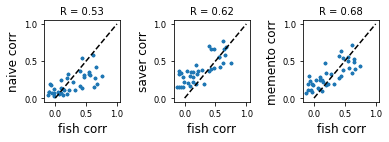

In [54]:
plt.figure(figsize=(6,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs], s=7)
plt.plot([0,1], [0,1], '--',color='k')
plt.xlabel('fish corr'); plt.ylabel('naive corr')
# print('naive', stats.pearsonr(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])[0])
plt.title('R = '+str(concordance(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])))
plt.title('R = '+str.format('{0:.2f}', concordance(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])))



plt.subplot(1,3,2)
plt.scatter(fish_corr_array[selected_pairs], saver_corrs[selected_pairs], s=7)
plt.plot([0,1], [0,1], '--',color='k')
plt.xlabel('fish corr'); plt.ylabel('saver corr')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
plt.title('R = '+str(concordance(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])))
plt.title('R = '+str.format('{0:.2f}', concordance(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])))

plt.subplot(1,3,3)
plt.scatter(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs], s=7)
plt.plot([0,1], [0,1], '--',color='k')
plt.xlabel('fish corr'); plt.ylabel('memento corr')
# print('memento', stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])[0])
plt.title('R = '+str.format('{0:.2f}', concordance(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])))

plt.savefig('coex_comparisons.png', dpi=300)